In [1]:
import numpy as np
import pandas as pd
# import scipy.io
# from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from tqdm import tqdm
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# load grat1

In [3]:
data_dir_grat = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1372_220714_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir_grat, vis_filter=False)
stim_id = stim_id[:trace_by_trial.shape[1]] # truncate to uncorrupted trials
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

ncell: 56, nstim: 1, ntrial: 219, nframe: 267
trace_cell_avg: (267,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (267,)


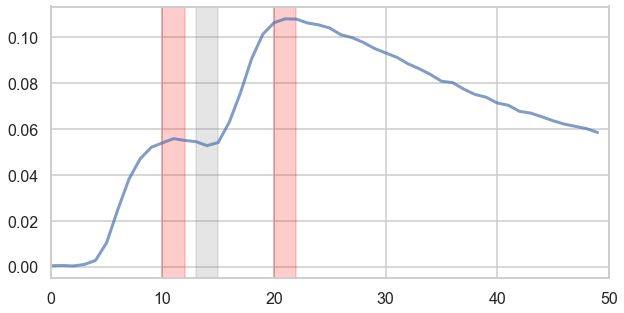

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(10, 12, alpha=0.2, color='red')
ax.axvspan(13, 15, alpha=0.2, color='gray')
ax.axvspan(20, 22, alpha=0.2, color='red')
plt.xlim(0, 50);

# adp
estimate how many trials to group together to get a stable adaptation value  
1. trace_by_trial shape: ncell x ntrial x nframe  
2. for each cell x trial, get resp_ad and resp_tg  
3. for whole population, loop thru trial numbers to group together to get a stable adaptation value  
3.1 measure adp value stability: plot group_size vs adp_mean & adp_std  
4. do this for each cell  
4.1 distribution of stable_group_size among cells  

In [5]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,10:12+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:15+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

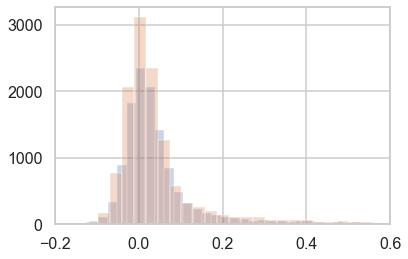

In [8]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

In [9]:
# # cap resp to thres_perc percentile of trials

# thres_perc = 1
# low, high = np.percentile(resp_ad.flatten(), [thres_perc, 100-thres_perc])
# resp_ad = np.clip(resp_ad, low, high)
# plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');

# low, high = np.percentile(resp_tg.flatten(), [thres_perc, 100-thres_perc])
# resp_tg = np.clip(resp_tg, low, high)
# plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');


## pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [19]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((219,), -0.3218938759212324, -0.11172270297723275)

In [20]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

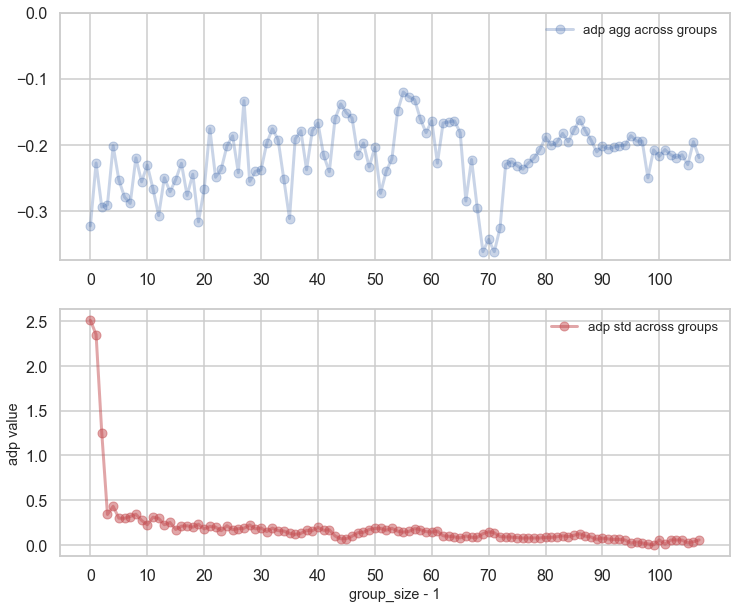

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.legend(frameon=False);

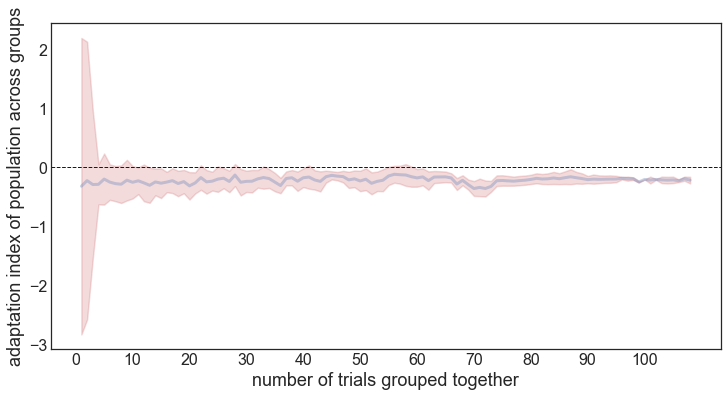

In [65]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

plt.style.use('seaborn-white')

fig = plt.figure(figsize=(12, 6))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population across groups', fontsize=18); #  across groups of different sizes

## single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [29]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

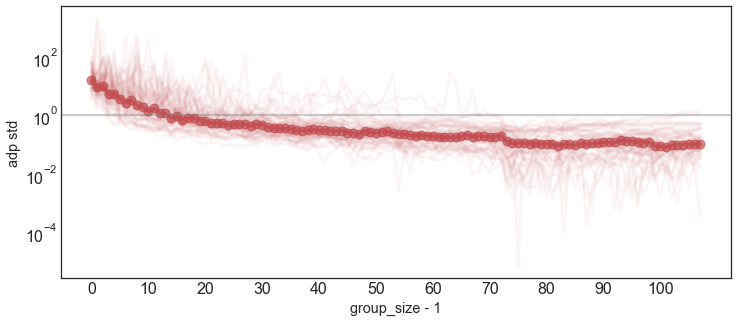

In [35]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, 'o-', color='r', linewidth=3, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

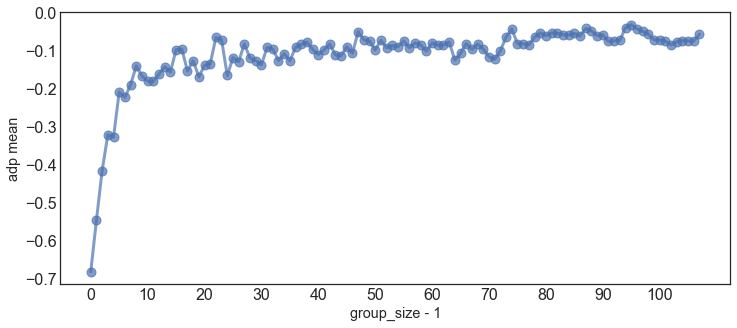

In [36]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

In [ ]:
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population', fontsize=18);

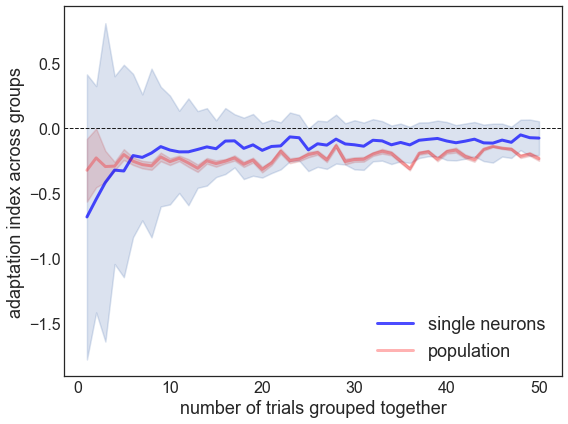

<Figure size 432x288 with 0 Axes>

In [70]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 50

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
fig.savefig(os.path.join(figpath, 'adp_stability_group_trials.pdf'), format='pdf')

# load mix50
mix50 stim: Z:\All_Staff\home\lan\Mwork\mix50 - bunnytop high lum contrast mix grating and noise\Image

ncell: 169, nstim: 50, ntrial: 1473, nframe: 203
trace_cell_avg: (203,).         trace_stim_avg list len: 50.         trace_stim_avg[0].shape: (203,)


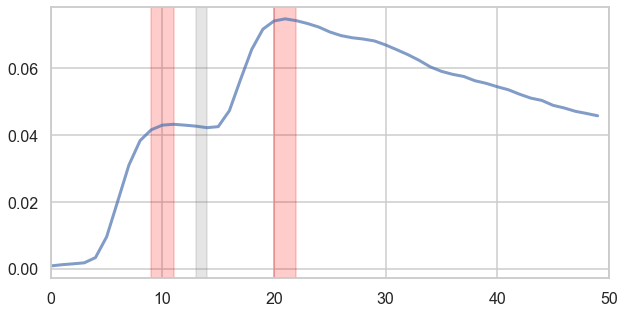

In [64]:
data_dir = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1373_220909_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir, vis_filter=True)
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,11, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,22, alpha=0.2, color='red')
plt.xlim(0, 50);

# trace by stim / type

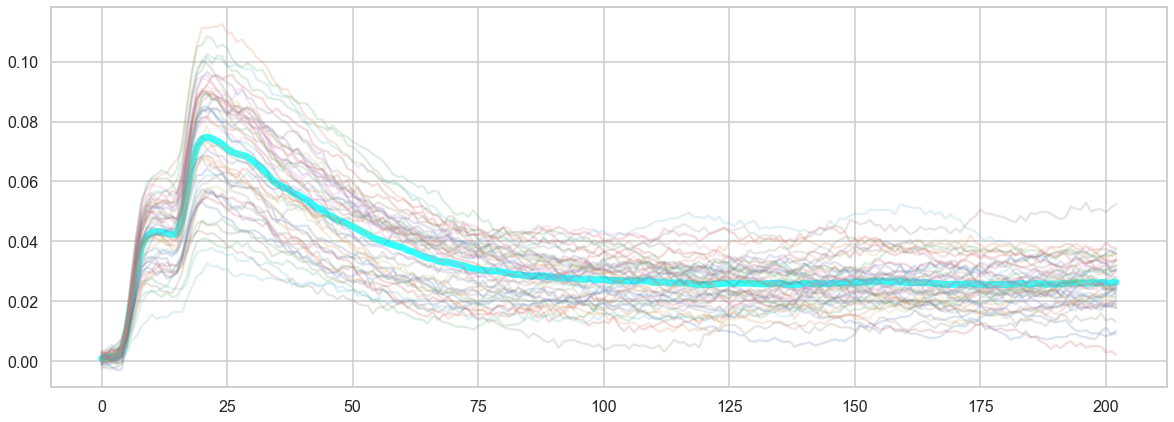

In [65]:
# plot trace for each stim
plt.figure(figsize=(20, 7))
plt.plot(trace_avg_cell, alpha=0.8, linewidth=7, color='cyan')
for i in np.unique(stim_id)-1:
    plt.plot(trace_stim_avg[i], alpha=0.2)

In [69]:
# plot trace for stim 1-30 (natural) vs stim 31-40 (grat) vs stim 41-50 (noise)

stim_type_dict = {'natural': [np.arange(1, 30+1)], 
                  'grat': [np.arange(31, 40+1)], 
                  'noise': [np.arange(41, 50+1)]}
for key in stim_type_dict.keys():
    print(key, np.min(stim_type_dict[key]), '-', np.max(stim_type_dict[key]))
    
trace_type_avg = []
trace_type_std = []
trace_type_sem = []

for key in stim_type_dict.keys():
    
    trace_itype_avg = np.mean(trace_by_trial[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]], axis=1) # ncell x nframe
    trace_itype_avg = np.mean(trace_itype_avg, axis=0) # nframe
    trace_itype_std = np.std(trace_by_trial[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]], axis=1)
    trace_itype_std = np.mean(trace_itype_std, axis=0)
    trace_itype_sem = trace_itype_std / np.sqrt(len(np.where((np.isin(stim_id, stim_type_dict[key])))[0]))

    trace_type_avg.append(trace_itype_avg)
    trace_type_std.append(trace_itype_std)
    trace_type_sem.append(trace_itype_sem)

len(trace_type_avg), trace_type_avg[0].shape

natural 1 - 30
grat 31 - 40
noise 41 - 50


(3, (203,))

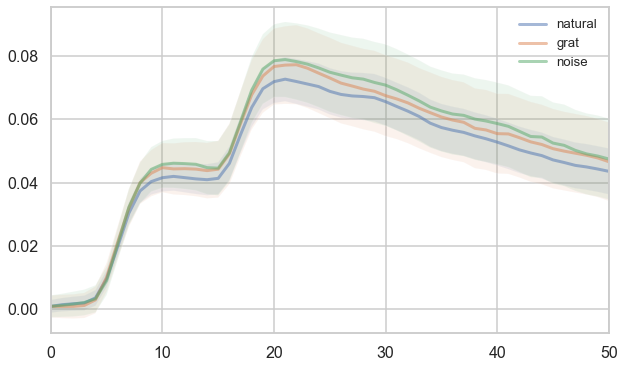

In [80]:
# plot trace for each stim type
plt.figure(figsize=(10, 6))

for i in np.arange(len(stim_type_dict.keys())):
    plt.plot(trace_type_avg[i], alpha=0.5, linewidth=3, label=list(stim_type_dict.keys())[i])
    errbar = trace_type_sem[i]
    plt.fill_between(np.arange(len(trace_type_avg[i])), 
                 trace_type_avg[i] + errbar, trace_type_avg[i] - errbar, 
                 alpha=0.1, label='')

plt.xlim(0,50)
plt.legend(frameon=False);

# adp by stim type

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline  
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum  
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

In [120]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

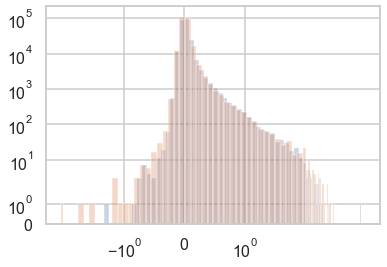

In [121]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xscale('symlog')
plt.yscale('symlog')

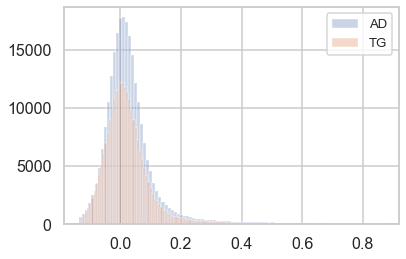

In [101]:
# # set extreme percentile resp to nan

# thres_perc_low = 0.5
# thres_perc_high = 0.5
# low, high = np.percentile(resp_ad.flatten(), [thres_perc_low, 100-thres_perc_high])
# # resp_ad = np.clip(resp_ad, low, high)
# resp_ad[resp_ad < low] = np.nan
# resp_ad[resp_ad > high] = np.nan
# plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');

# low, high = np.percentile(resp_tg.flatten(), [thres_perc, 100-thres_perc])
# # resp_tg = np.clip(resp_tg, low, high)
# resp_tg[resp_tg < low] = np.nan
# resp_tg[resp_tg > high] = np.nan
# plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG')
# plt.legend();

## agg over all cell all trial

In [122]:
agg_fun = np.nansum

resp_ad_pop = agg_fun(resp_ad, axis=0) # population response as agg of all cells for each trial
resp_tg_pop = agg_fun(resp_tg, axis=0)

df = pd.DataFrame()
df['stim_id'] = stim_id
df['stim_type'] = np.where(np.isin(stim_id, stim_type_dict['natural']), 'natural',
                  np.where(np.isin(stim_id, stim_type_dict['grat']), 'grat',
                  np.where(np.isin(stim_id, stim_type_dict['noise']), 'noise', 'other')))
df['resp_ad_pop'] = resp_ad_pop
df['resp_tg_pop'] = resp_tg_pop
# df = df.sort_values(by=['stim_id'])
df

,stim_id,stim_type,resp_ad_pop,resp_tg_pop
0,32,grat,1.680197,5.306906
1,45,noise,12.307765,-4.836964
2,7,natural,4.188633,1.791924
3,49,noise,6.994136,9.806641
4,47,noise,11.916840,13.589329
...,...,...,...,...
1468,5,natural,0.211943,2.215691
1469,14,natural,0.123511,1.570731
1470,21,natural,3.161614,1.386599
1471,31,grat,1.202276,1.637006


In [123]:
df_pop = df.groupby('stim_type').sum() # agg pop resp of all trials for each stim type
df_pop['adp_pop_type'] = (df_pop['resp_tg_pop'] - df_pop['resp_ad_pop']) / (df_pop['resp_ad_pop'] + 1e-7)
df_pop

,stim_id,resp_ad_pop,resp_tg_pop,adp_pop_type
stim_type,,,,
grat,10329,2123.134664,1624.032467,-0.235078
natural,13707,5977.808428,4659.929439,-0.220462
noise,13505,2215.997227,1672.009905,-0.245482


## bootstrap 20 out of 30 trials

In [ ]:
'''
for each stim id, get resp_ad and resp_tg [ncell x trial_rep x nstim]
bootstrap select 20 trials out of trial_rep

sum over 20 trials to get resp & adp [ncell x nstim]
associate w spatial freq
    add img_driven filter to pop resp

heatmap of resp or adp [ncell x nstim] or [ncell x nstim_type]
or venn diagram of cells responsive / adapting to stim
sort cells by resp or adp to stim, then plot in this order to other stim

regroup into stim type to get resp & adp [ncell x nstim_type]
sum over cells to get pop resp & pop adp [nstim_type] or [nstim]
    add img_driven filter to pop resp

'''

In [232]:
# associate w spatial freq after bootstrap. pop resp w img_driven filter

data_dir = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1373_220909_cellpose'
with open(data_dir + "/vis_driven.pickle", "rb") as handle:
    vis = pickle.load(handle)
# vis.keys()

vis_driven = vis["vis_driven"]
vis_driven = [v[0] for v in vis_driven]
img_driven = vis['img_driven']

img_driven = img_driven[vis_driven, :] # filter out non-vis driven cells. match shape of resp_ad
img_driven = img_driven
img_driven.shape

(169, 50)

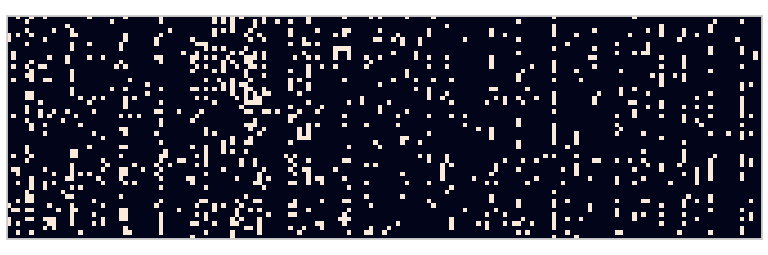

In [272]:
plt.matshow(img_driven.T)
plt.xticks([]) # no axis ticks
plt.yticks([]);

In [255]:
# reshape resp_ad and resp_tg to list array: nstim x [ncell x trial_rep]
# using img_driven filter

resp_ad_by_stim = []
resp_tg_by_stim = []

for istim in np.unique(np.sort(stim_id)):
    istim_id = np.where(stim_id == istim)[0] # which trial has this stim
    
    resp_ad_istim = resp_ad[:, istim_id]
    resp_ad_istim[img_driven[:, istim-1] == False, :] = np.nan # stim id starts from 1, but index starts from 0
    resp_ad_by_stim.append(resp_ad_istim)
    resp_tg_istim = resp_tg[:, istim_id]
    resp_tg_istim[img_driven[:, istim-1] == False, :] = np.nan
    resp_tg_by_stim.append(resp_tg_istim)

len(resp_ad_by_stim), [i.shape for i in resp_ad_by_stim[:5]]

(50, [(169, 30), (169, 30), (169, 29), (169, 30), (169, 30)])

In [264]:
# img_driven.sum(axis=0), [np.sum(~np.isnan(i.sum(axis=1))) for i in resp_ad_by_stim]

In [265]:
# select 20 trials out of trial_rep

def trial_rep_select(arr, n):
    '''
    arr: array to select from. shape [ncell x trial_rep]
    n: number of samples to select
    '''
    ntrial = arr.shape[1]
    idx = np.random.choice(ntrial, n, replace=True)
    return arr[:,idx]

t = trial_rep_select(resp_ad_by_stim[0], 20)
len(t), t[0].shape

(169, (20,))

(50, 169)


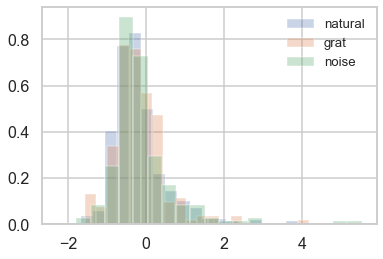

In [267]:
# sum over 20 trials to get resp & adp [nstim x ncell]

R1_agg_stim = np.array([trial_rep_select(i, 20).sum(axis=1) for i in resp_ad_by_stim]) # sum over 20 trial reps
R2_agg_stim = np.array([trial_rep_select(i, 20).sum(axis=1) for i in resp_tg_by_stim])

adp_stim = (R2_agg_stim - R1_agg_stim) / (R1_agg_stim + 1e-7)
adp_stim[np.abs(adp_stim) > 10] = np.nan
print(adp_stim.shape)

# plt.hist(adp_stim.ravel(), bins=100, alpha=0.3, label='stim');
plt.hist(adp_stim[:30, :].ravel(), bins=20, alpha=0.3, label='natural', density=True);
plt.hist(adp_stim[30:40, :].ravel(), bins=20, alpha=0.3, label='grat', density=True);
plt.hist(adp_stim[40:, :].ravel(), bins=20, alpha=0.3, label='noise', density=True);
plt.legend(frameon=False);

C:\Users\ll357\AppData\Local\Temp\4\ipykernel_50616\3133609232.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
C:\Users\ll357\AppData\Local\Temp\4\ipykernel_50616\3133609232.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


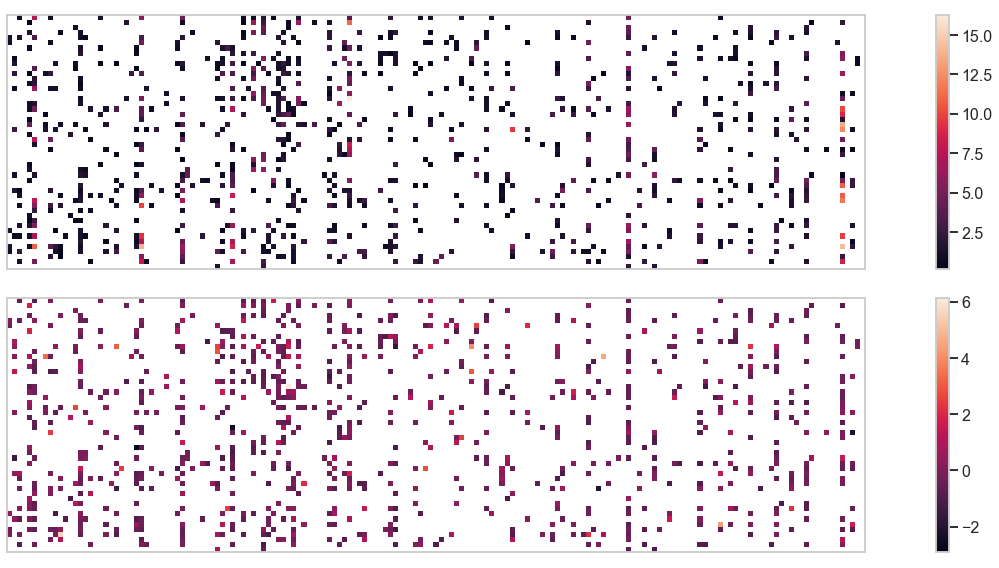

In [273]:
# resp matrix [nstim x ncell] w img_driven filter

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.matshow(R1_agg_stim, fignum=False)
plt.xticks([]) # no axis ticks
plt.yticks([]);
plt.colorbar()

plt.subplot(2,1,2)
plt.matshow(adp_stim, fignum=False)
plt.xticks([]) # no axis ticks
plt.yticks([]);
plt.colorbar()
plt.tight_layout()

In [274]:
# adp_stim_pop = np.nanmean(adp_stim, axis=1)
# adp_stim_pop.shape

# # plt.plot(np.arange(50), adp_stim_pop);
# plt.plot(np.arange(20), adp_stim_pop[30:]);
# # adp_stim_pop

In [275]:
# associate w spatial freq after bootstrap. pop resp

nboot = 100
adp_stim_boot = np.zeros((nboot, adp_stim.shape[0], adp_stim.shape[1]))
for i in np.arange(nboot):
    R1_agg_stim = np.array([trial_rep_select(i, 20).sum(axis=1) for i in resp_ad_by_stim]) # sum over 20 trial reps
    R2_agg_stim = np.array([trial_rep_select(i, 20).sum(axis=1) for i in resp_tg_by_stim])

    adp_stim = (R2_agg_stim - R1_agg_stim) / (R1_agg_stim + 1e-7)
    adp_stim[np.abs(adp_stim) > 10] = np.nan
    adp_stim_boot[i] = adp_stim

adp_stim_boot.shape

(100, 50, 169)

In [289]:
cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2)
cpd_array

array([0.03, 0.04, 0.06, 0.09, 0.14, 0.2 , 0.29, 0.42, 0.62, 0.9 ])

In [297]:
img_driven[:, 30:40].shape

np.sum(img_driven[:, 30:], axis=0)

array([10, 20, 26, 22, 24, 20, 24, 25,  9,  4, 11, 26, 18, 22, 21, 27, 28,
       16, 22,  4])

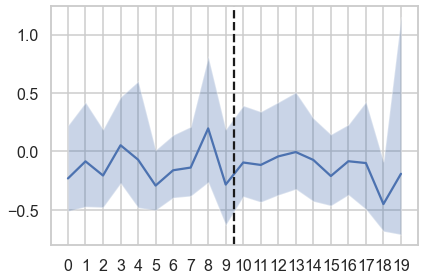

In [296]:
adp_stim_boot_pop = np.nanmean(adp_stim_boot, axis=2) # [nboot x nstim], avg over cells
adp_stim_pop_mean = np.nanmean(adp_stim_boot_pop, axis=0) # [nstim], avg over boot
adp_stim_pop_err = np.nanstd(adp_stim_boot_pop, axis=0)

adp_stim_pop_CI95 = np.nanpercentile(adp_stim_boot_pop, [2.5, 97.5], axis=0) # [2 x nstim], 95% CI

plt.figure(figsize=(8,5))
# plt.subplot(2,1,1)
# plt.plot(np.arange(20), adp_stim_pop_mean[30:]);
# plt.fill_between(np.arange(20), adp_stim_pop_mean[30:] - adp_stim_pop_err[30:], adp_stim_pop_mean[30:] + adp_stim_pop_err[30:], alpha=0.3);
# plt.axvline(10-0.5, color='k', linestyle='--')
# plt.xticks(np.arange(20))

# plt.subplot(2,1,2)
plt.plot(np.arange(20), adp_stim_pop_mean[30:]);
plt.fill_between(np.arange(20), adp_stim_pop_CI95[0, 30:], adp_stim_pop_CI95[1, 30:], alpha=0.3);
plt.axvline(10-0.5, color='k', linestyle='--')
plt.xticks(np.arange(20))
plt.tight_layout()


## before

In [128]:
adp_type = []
# thres = 5
print(resp_ad.shape)

for key in stim_type_dict.keys():
    
    resp_ad_type = resp_ad[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]]
    resp_ad_type = np.sum(resp_ad_type, axis=1) # [ncell]. sum over trials of same stim type
    resp_tg_type = resp_tg[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]]
    resp_tg_type = np.sum(resp_tg_type, axis=1)

    adp_type_now = (resp_tg_type - resp_ad_type) / (resp_ad_type + 1e-7)

    thres_perc_low = 0.5
    thres_perc_high = 0.5
    low, high = np.nanpercentile(adp_type_now.flatten(), [thres_perc_low, 100-thres_perc_high])
    adp_type_now[adp_type_now < low] = np.nan
    adp_type_now[adp_type_now > high] = np.nan

    # adp_type_now[np.abs(adp_type_now) > thres] = np.nan
    adp_type.append(adp_type_now) # [ntype, ncell]

# adp_type = np.array(adp_type)
adp_type[0].shape, len(adp_type)

(169, 1473)


((169,), 3)

In [129]:
df = pd.DataFrame()
for i,key in enumerate(stim_type_dict.keys()):
    print(i, key)
    df_type = pd.DataFrame(adp_type[i], columns=['adp'])
    df_type['type'] = key
    df = pd.concat([df, df_type])
df = df.reset_index(drop=True)
df

0 natural
1 grat
2 noise


,adp,type
0,0.124442,natural
1,0.102675,natural
2,-0.138624,natural
3,-0.919008,natural
4,-0.003472,natural
...,...,...
502,-0.349714,noise
503,NaN,noise
504,0.001791,noise
505,-0.004657,noise


In [132]:
adp_type_agg = [np.nanmedian(i) for i in adp_type]
# adp_type_agg, stim_type_dict.keys()

df.groupby('type').adp.median()

type
grat      -0.198998
natural   -0.139543
noise     -0.151561
Name: adp, dtype: float64

(-1.0, 1.0)

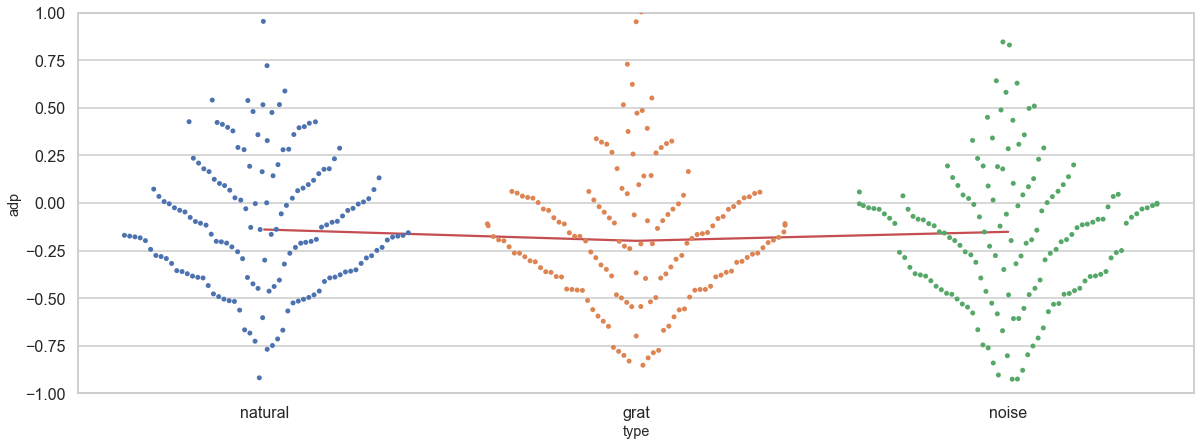

In [133]:
# swarmplot of adp_type
plt.figure(figsize=(20, 7))
ax = sns.swarmplot(x="type", y="adp", data=df)
plt.plot(adp_type_agg, 'r')
plt.ylim(-1,1)

# sns.swarmplot(data=adp_type[0], palette='Set1')
# plt.xlabel('ADP type'); plt.ylabel('ADP');
# plt.title('ADP type');
# plt.legend(list(stim_type_dict.keys()), frameon=False);


In [ ]:
# use pop resp. group all 9-10 trials together for each stim, then compare stim type


# # for whole population, loop thru trial numbers to group together to get a stable adaptation value  
# adp_agg = []
# adp_std = []
# for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
#     ngroup = trace_by_trial.shape[1] // group_size

#     resp_ad_cut = resp_ad_pop[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
#     resp_tg_cut = resp_tg_pop[:group_size*ngroup].reshape(ngroup, group_size)
#     resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
#     resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

#     adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
#     adp_group_agg = mean_or_median(adp_group) # agg adp across group
#     adp_group_std = np.std(adp_group) # std of adp across group
#     adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
#     adp_std.append(adp_group_std)

# adp_agg = np.array(adp_agg)
# adp_std = np.array(adp_std)
# adp_sem = adp_std / np.sqrt(adp_std.shape[0])